# Advanced Lane Lines

### Initial Camera Calibration

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import glob
from CameraOperations import show_grid, correct_distortion, calibrate_camera_from_folder
import os
import pickle

print("Calibrating camera on images in camera_cal...")
%time mtx, dist = calibrate_camera_from_folder("./camera_cal",name_pattern="calibration*.jpg", counts=(9,6))
print("Done Calibrating.")
global_mtx = mtx
global_dist = dist

print("Correcting calibration images...")
test_images = os.listdir("camera_cal/")
for img in test_images:
    cal_image = mpimg.imread('camera_cal/'+img)
    cal_un_dst = correct_distortion(cal_image, global_mtx, global_dist)
    mpimg.imsave("corrected_images/adj_"+img, cal_un_dst)

# Correct the test images
print("Correcting test images...")
test_images = os.listdir("test_images/")
for img in test_images:
    image = mpimg.imread('test_images/'+img)
    un_dst = correct_distortion(image, global_mtx, global_dist)
    mpimg.imsave("corrected_images/adj_"+img, un_dst)
    
show_grid((cal_image, cal_un_dst), ("Orginal", "Corrected"), ticks=(320,80))
show_grid((image, un_dst), ("Test Image", "Corrected Test Image"), ticks=(320,80))
#global_mtx, global_dist

#Save a dictionary to a pickle file
pickle_dict = {'mtx': global_mtx, 'dist': global_dist}
pickle.dump(pickle_dict, open("./camera_parameters.p", "wb"))

In [ ]:
image2 = mpimg.imread("./camera_cal/calibration2.jpg")
image3 = mpimg.imread("./camera_cal/calibration3.jpg")
image2_undst = mpimg.imread("./corrected_images/adj_calibration2.jpg")
image3_undst = mpimg.imread("./corrected_images/adj_calibration3.jpg")

show_grid((image2, image2_undst), ("Orginal", "Corrected"), ticks=(320,80))
show_grid((image3, image3_undst), ("Original", "Corrected"), ticks=(320,80))


### Test on multiple images

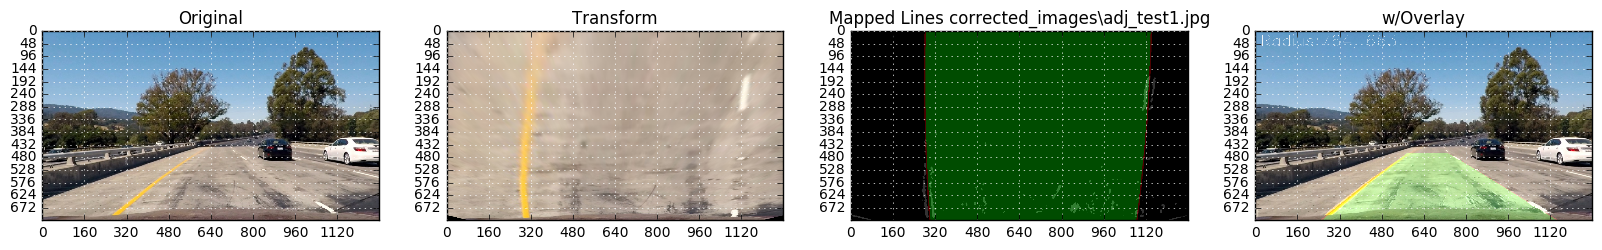

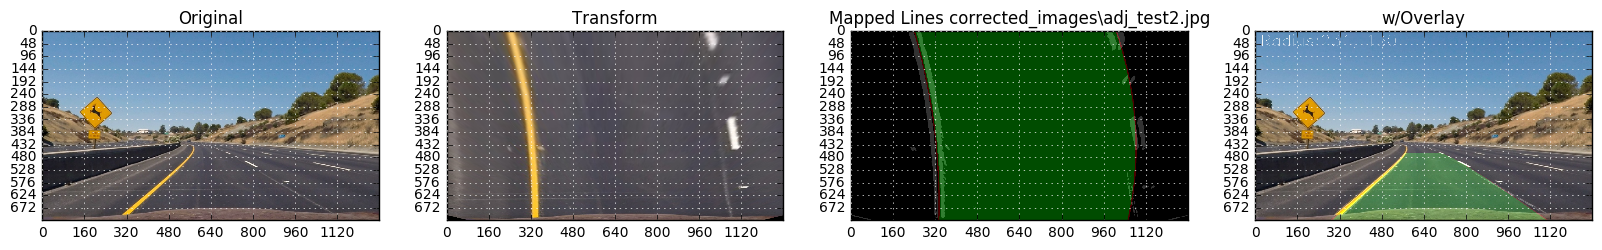

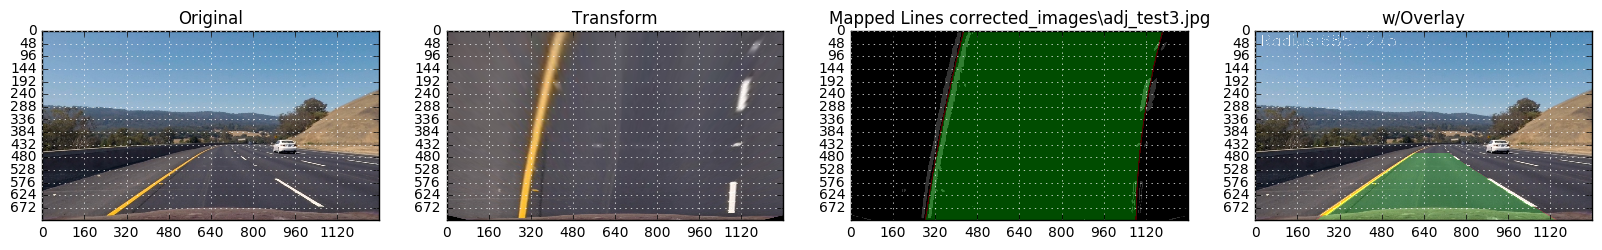

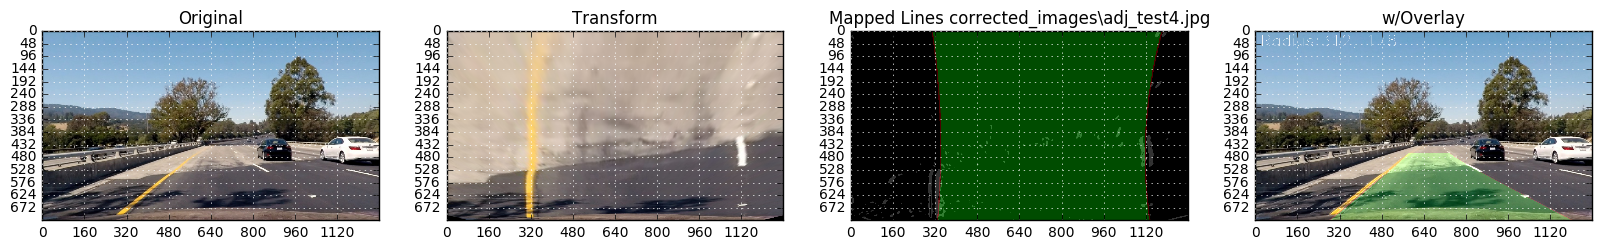

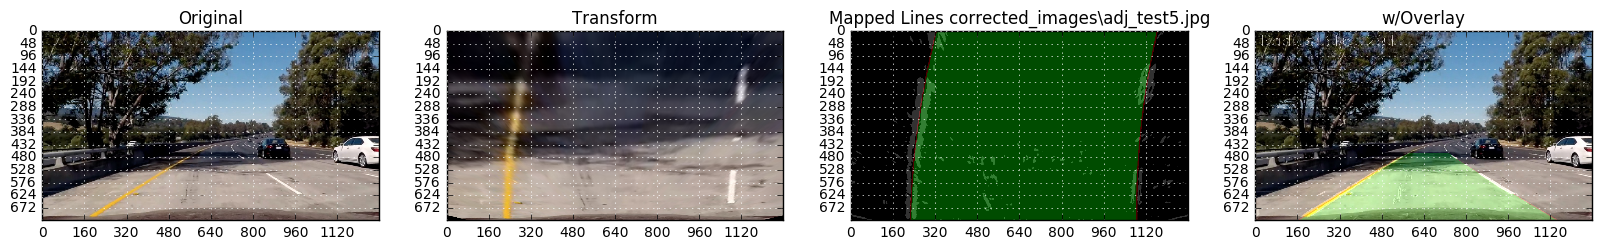

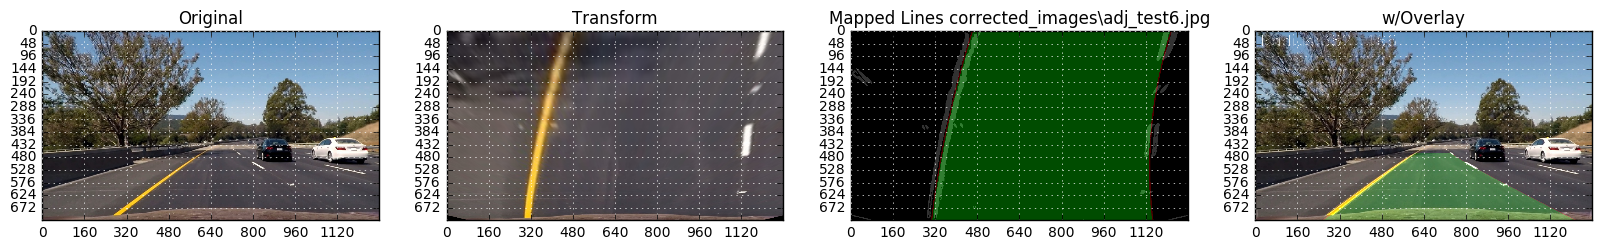

In [22]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import glob
from CameraOperations import show_grid, correct_distortion, perspective_transform, sobel_LR_threshold
from LaneOperations import map_lane_lines
from ImageProcessing import image_gradient, image_preprocessing, gaussian_blur, image_sharpen
import pickle

#Load a pickle file
with open("./camera_parameters.p", mode='rb') as f:
    camera_params = pickle.load(f)
global_dist = camera_params['dist']
global_mtx = camera_params['mtx']
viewport = [[540,465],[740,465],[1280,720],[0,720]]   # New Viewport (vanishing point intersection)
offset = 80
sobel_thresh=(30, 150)
gradient_thresh=(0.7, 1.2)
sobel_kernel=15
s_thresh=(170,240)

images = glob.glob("corrected_images/adj_test*.jpg")
for img in images:
    image = mpimg.imread(img)
    xform = perspective_transform(image, viewport, offset=80)
    mapped_lanes, lane_markings,cache = map_lane_lines(image,window_width=40,window_height=48,margin=40) #,DEBUG=True,DEBUG_ID=img)
    show_grid((image, xform, mapped_lanes, lane_markings), ("Original","Transform", "Mapped Lines "+img, "w/Overlay"), ticks=(160,48))


### Try it on video

In [23]:
import imageio
#imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

idx=0
cache = None
def make_frame_lane_markings(image):
    global idx
    global cache
    DEBUG = True
    un_dst = correct_distortion(image, global_mtx, global_dist)
    mapped_lanes, lane_markings, cache = map_lane_lines(un_dst, window_width=40, window_height=48, margin=40, cache=cache)
    if DEBUG:
        mpimg.imsave("debug_images/{0}_overlay.jpg".format(idx), lane_markings)
        mpimg.imsave("debug_images/{0}_mapped_lanes.jpg".format(idx), mapped_lanes)
        mpimg.imsave("debug_images/{0}.jpg".format(idx), un_dst)
    idx = idx + 1
    return lane_markings

clip_output = "./marked_v5_project_video.mp4" # marked_v4_harder_challenge
clip_handle = VideoFileClip("project_video.mp4", audio=False)
img_clip = clip_handle.fl_image(make_frame_lane_markings) 
%time img_clip.write_videofile(clip_output, audio=False)

[MoviePy] >>>> Building video ./marked_v5_project_video.mp4
[MoviePy] Writing video ./marked_v5_project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [06:36<00:00,  3.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./marked_v5_project_video.mp4 

Wall time: 6min 37s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(clip_output))

### Trying various filters to find the best match

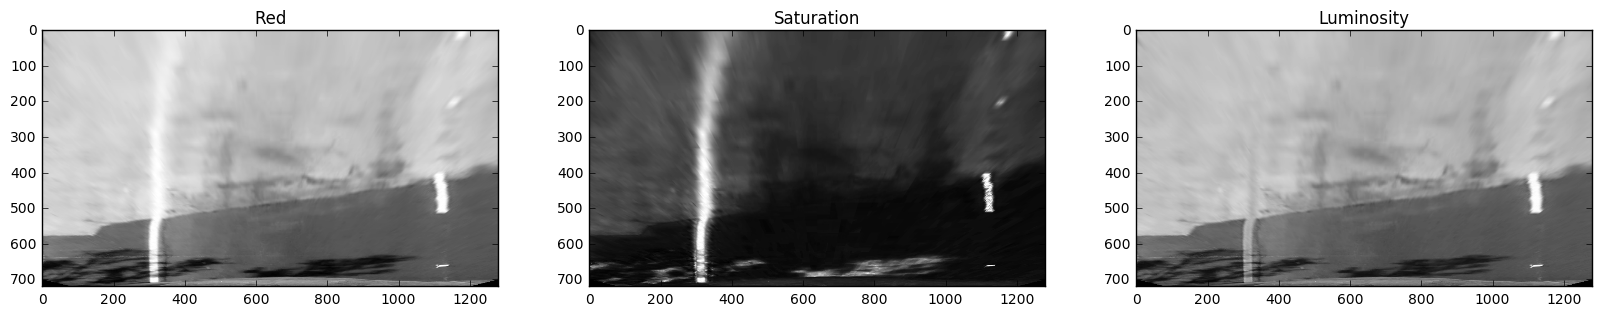

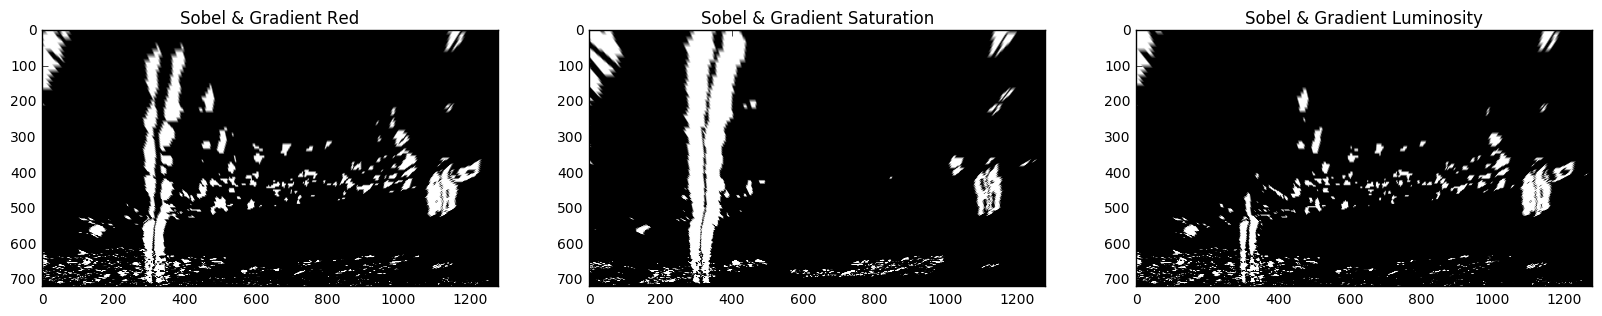

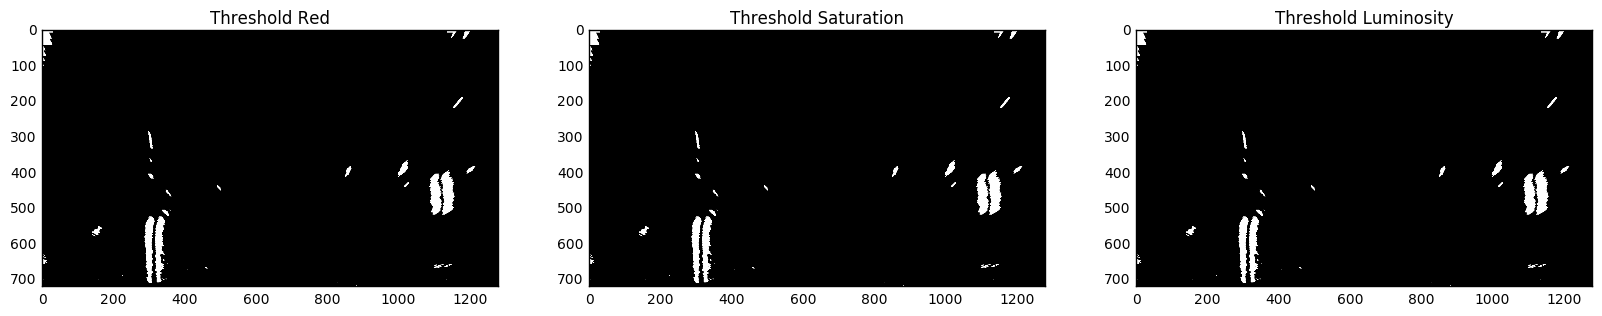

In [56]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import numpy as np

from CameraOperations import sobel_threshold, gradient_threshold, sobel_and_gradient, sobel_LSR_threshold, show_grid
from CameraOperations import threshold_rgb, threshold_hls
from ImageProcessing import image_preprocessing, augment_brightness_camera_images, image_sharpen
from LaneOperations import perspective_transform

#img_id = 206
#image = mpimg.imread("./debug_images3/{0}.jpg".format(img_id))

img_id = "1189"
#image = mpimg.imread("./debug_images-harder_challenge_video/{0}.jpg".format(img_id))
#image = mpimg.imread("signs_vehicles_xygrad.png")
image = mpimg.imread("corrected_images/adj_test4.jpg")
#image = image_sharpen(image)
w = image.shape[1]
h = image.shape[0]
viewport = [[540,465],[740,465],[1280,720],[0,720]]
#viewport = [[round(w/2-105),round(h*.65)],[round(w/2+105),round(h*.65)],[w,h],[0,h]]
#image = perspective_transform(image, viewport=viewport, offset=0, reverse=False)
r = image[:,:,0]
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
s = hls[:,:,2]
l = hls[:,:,1]

r_v = perspective_transform(r, viewport=viewport, offset=80, reverse=False)
l_v = perspective_transform(l, viewport=viewport, offset=80, reverse=False)
s_v = perspective_transform(s, viewport=viewport, offset=80, reverse=False)

show_grid((r_v,s_v,l_v), ("Red", "Saturation", "Luminosity"))

sobel_thresh=(20, 150)
gradient_thresh=(0.7, 1.3)
sobel_kernel=15

def gradient_threshold2(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    gradient = np.arctan2(sobely, sobelx)
    sxbinary = np.zeros_like(gradient)
    sxbinary[(gradient >= thresh[0]) & (gradient <= thresh[1])] = 1
    return sxbinary

def sobel_and_gradient2(img, sobel_kernel=3, sobel_thresh=(80, 160), gradient_thresh=(0, np.pi/2)):
    gradx = sobel_threshold(img, orient='x', sobel_kernel=sobel_kernel, thresh=sobel_thresh)
    grady = sobel_threshold(img, orient='y', sobel_kernel=sobel_kernel, thresh=sobel_thresh)
    mag_binary = sobel_threshold(img, orient='both', sobel_kernel=sobel_kernel, thresh=sobel_thresh)
    dir_binary = gradient_threshold2(img, sobel_kernel=sobel_kernel, thresh=gradient_thresh)
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

DEBUG2 = False
if DEBUG2:
    sobel_r = sobel_threshold(r, orient='y', sobel_kernel=sobel_kernel, thresh=sobel_thresh)
    sobel_s = sobel_threshold(s, orient='y', sobel_kernel=sobel_kernel, thresh=sobel_thresh)
    sobel_l = sobel_threshold(l, orient='y', sobel_kernel=sobel_kernel, thresh=sobel_thresh)
    show_grid((sobel_r,sobel_s,sobel_l), ("Sobel(Y) Red", "Sobel(Y) Saturation", "Sobel(Y) Luminosity"))

    sobel_r = sobel_threshold(r, orient='x', sobel_kernel=sobel_kernel, thresh=sobel_thresh)
    sobel_s = sobel_threshold(s, orient='x', sobel_kernel=sobel_kernel, thresh=sobel_thresh)
    sobel_l = sobel_threshold(l, orient='x', sobel_kernel=sobel_kernel, thresh=sobel_thresh)
    show_grid((sobel_r,sobel_s,sobel_l), ("Sobel(X) Red", "Sobel(X) Saturation", "Sobel(X) Luminosity"))

    sobel_r = sobel_threshold(r, orient='both', sobel_kernel=sobel_kernel, thresh=sobel_thresh)
    sobel_s = sobel_threshold(s, orient='both', sobel_kernel=sobel_kernel, thresh=sobel_thresh)
    sobel_l = sobel_threshold(l, orient='both', sobel_kernel=sobel_kernel, thresh=sobel_thresh)
    show_grid((sobel_r,sobel_s,sobel_l), ("Sobel(Both) Red", "Sobel(Both) Saturation", "Sobel(Both) Luminosity"))

    grad_r = gradient_threshold2(r, sobel_kernel=sobel_kernel, thresh=gradient_thresh)
    grad_l = gradient_threshold2(l, sobel_kernel=sobel_kernel, thresh=gradient_thresh)
    grad_s = gradient_threshold2(s, sobel_kernel=sobel_kernel, thresh=gradient_thresh)
    show_grid((grad_r,grad_s,grad_l), ("Gradient Red", "Gradient Saturation", "Gradient Luminosity"))

sg_r = sobel_and_gradient(r, sobel_kernel=sobel_kernel, sobel_thresh=sobel_thresh, gradient_thresh=gradient_thresh)
sg_l = sobel_and_gradient(l, sobel_kernel=sobel_kernel, sobel_thresh=sobel_thresh, gradient_thresh=gradient_thresh)
sg_s = sobel_and_gradient(s, sobel_kernel=sobel_kernel, sobel_thresh=sobel_thresh, gradient_thresh=gradient_thresh)
sg_r = perspective_transform(sg_r, viewport=viewport, offset=80, reverse=False)
sg_l = perspective_transform(sg_l, viewport=viewport, offset=80, reverse=False)
sg_s = perspective_transform(sg_s, viewport=viewport, offset=80, reverse=False)
show_grid((sg_r,sg_s,sg_l), ("Sobel & Gradient Red", "Sobel & Gradient Saturation", "Sobel & Gradient Luminosity"))

t_r = sobel_LR_threshold(image, sobel_kernel=15, sobel_thresh=(30, 150))
t_l = sobel_LR_threshold(image, sobel_kernel=15, sobel_thresh=(30, 150))
t_s = sobel_LR_threshold(image, sobel_kernel=15, sobel_thresh=(30, 150))
t_r = perspective_transform(t_r, viewport=viewport, offset=80, reverse=False)
t_l = perspective_transform(t_l, viewport=viewport, offset=80, reverse=False)
t_s = perspective_transform(t_s, viewport=viewport, offset=80, reverse=False)
show_grid((t_r, t_s, t_l), ("Threshold Red", "Threshold Saturation", "Threshold Luminosity"))
